<a href="https://colab.research.google.com/github/nov05/Google-Colaboratory/blob/master/generative_ai_with_langchain/05_08_plan_and_solve_agent.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

* Notebook modified by nov05 on 2025-06-11

In [1]:
%%capture
!pip install langchain_google_vertexai langchain_core langgraph langchain-community
## Successfully installed httpx-sse-0.4.0 langchain_google_vertexai-2.0.24 pyarrow-19.0.1 validators-0.35.0
## Successfully installed langgraph-0.4.8 langgraph-checkpoint-2.0.26 langgraph-prebuilt-0.2.2 langgraph-sdk-0.1.70 ormsgpack-1.10.0
## Successfully installed dataclasses-json-0.6.7 langchain-community-0.3.25 langchain-core-0.3.65 langsmith-0.3.45 marshmallow-3.26.1 mypy-extensions-1.1.0 pydantic-settings-2.9.1 python-dotenv-1.1.0 typing-inspect-0.9.0
!pip install -U duckduckgo-search
## Successfully installed duckduckgo-search-8.0.3 primp-0.15.0
!pip install arxiv
## Successfully installed arxiv-2.2.0 feedparser-6.0.11 sgmllib3k-1.0.0
!pip install wikipedia
## Successfully installed wikipedia-1.4.0

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
from google.oauth2 import service_account
json_path = "/content/drive/MyDrive/config/20250604_google_service_account_key-lucid-bebop-461722-c5-a91d4ab1be75.json"
credentials = service_account.Credentials.from_service_account_file(json_path)
credentials

# 🟢 **Plan and solve agent**  

We'll begin with the planner functionality, and define the data structure and the corresponding instructions:

In [4]:
from pydantic import BaseModel, Field
from langchain_core.prompts import ChatPromptTemplate
from langchain_google_vertexai import ChatVertexAI

class Plan(BaseModel):
    """Plan to follow in future"""
    steps: list[str] = Field(
        description="different steps to follow, should be in sorted order"
    )

system_prompt_template = (
    "For the given task, come up with a step by step plan.\n"
    "This plan should involve individual tasks, that if executed correctly will "
    "yield the correct answer. Do not add any superfluous steps.\n"
    "The result of the final step should be the final answer. Make sure that each "
    "step has all the information needed - do not skip steps."
)
planner_prompt = ChatPromptTemplate.from_messages(
    [("system", system_prompt_template),
     ("user", "Prepare a plan how to solve the following task:\n{task}\n")])
planner = planner_prompt | ChatVertexAI(
    # model_name="gemini-1.5-pro-002",
    model="gemini-2.0-flash-001",
    project="lucid-bebop-461722-c5",  ## ✅ mandatory
    credentials=credentials,          ## ✅ mandatory
    temperature=1.0,
).with_structured_output(Plan)

We will re-use tools we built in previous sections:

In [5]:
from pydantic import BaseModel, Field
import numexpr as ne
from langchain_core.runnables import RunnableLambda, RunnableConfig
from langchain_core.tools import tool, convert_runnable_to_tool

class CalculatorArgs(BaseModel):
    expression: str = Field(description="Mathematical expression to be evaluated")

def calculator(state: CalculatorArgs, config: RunnableConfig) -> str:
    expression = state["expression"]
    math_constants = config["configurable"].get("math_constants", {})
    result = ne.evaluate(expression.strip(), local_dict=math_constants)
    return str(result)

calculator_with_retry = RunnableLambda(calculator).with_retry(
    wait_exponential_jitter=True,
    stop_after_attempt=3,
)
calculator_tool = convert_runnable_to_tool(
    calculator_with_retry,
    name="calculator",
    description=(
        "Calculates a single mathematical expression, incl. complex numbers."
        "'\nAlways add * to operations, examples:\n73i -> 73*i\n"
        "7pi**2 -> 7*pi**2"
    ),
    args_schema=CalculatorArgs,
    arg_types={"expression": "str"},
)

In [6]:
from langchain.agents import load_tools
llm = ChatVertexAI(
    # model="gemini-1.5-pro-002",
    model="gemini-2.0-flash-001",
    project="lucid-bebop-461722-c5",  ## ✅ mandatory
    credentials=credentials,          ## ✅ mandatory
)
tools = load_tools(
    tool_names=["ddg-search", "arxiv", "wikipedia"],
    llm=llm
)

We will use these tools with a ReACT agent:

In [7]:
from langgraph.prebuilt import create_react_agent
from langgraph.prebuilt.chat_agent_executor import AgentState
from langchain_core.prompts import ChatPromptTemplate

class StepState(AgentState):
  plan: str
  step: str
  task: str

system_prompt = (
    "You're a smart assistant that carefully helps to solve complex tasks.\n"
    "Given a general plan to solve a task and a specific step, work on this step. "
    "Don't assume anything, keep in minds things might change and always try to "
    "use tools to double-check yourself.\n"
    "Use a calculator for mathematical computations, use Search to gather "
    "for information about common facts, fresh events and news, use Arxiv to get "
    "ideas on recent research and use Wikipedia for common knowledge."
)
step_template = (
    "Given the task and the plan, try to execute on a specific step of the plan.\n"
    "TASK:\n{task}\n\nPLAN:\n{plan}\n\nSTEP TO EXECUTE:\n{step}\n"
)
prompt_template = ChatPromptTemplate.from_messages([
    ("system", system_prompt),
    ("user", step_template),
])
execution_agent = create_react_agent(
    model=llm,
    tools=tools+[calculator_tool],
    state_schema=StepState,
    prompt=prompt_template
)

Now it's time to define our agent's state:

In [8]:
from typing import Annotated, TypedDict
import operator
task = "Write a strategic one-pager of building an AI startup?"

In [9]:
class PlanState(TypedDict):
    task: str
    plan: Plan
    past_steps: Annotated[list[str], operator.add]
    final_response: str

def get_current_step(state: PlanState) -> int:
    """Returns the number of current step to be executed."""
    return len(state.get("past_steps", []))

def get_full_plan(state: PlanState) -> str:
    """Returns formatted plan with step numbers and past results."""
    full_plan = []
    for i, step in enumerate(state["plan"].steps):
        full_step = f"# {i+1}. Planned step: {step}\n"
        if i < get_current_step(state):
            full_step += f"Result: {state['past_steps'][i]}\n"
            full_plan.append(full_step)
    return "\n".join(full_plan)

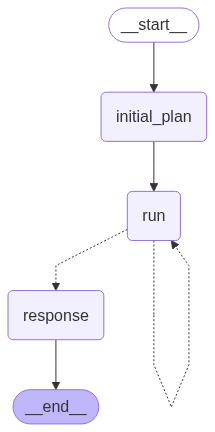

In [10]:
from typing import Literal
from langchain_core.prompts import PromptTemplate
from langgraph.graph import StateGraph, START, END

final_prompt = PromptTemplate.from_template(
    "You're a helpful assistant that has executed on a plan."
    "Given the results of the execution, prepare the final response.\n"
    "Don't assume anything\nTASK:\n{task}\n\nPLAN WITH RESUlTS:\n{plan}\n"
    "FINAL RESPONSE:\n"
)

async def _build_initial_plan(state: PlanState) -> PlanState:
    plan = await planner.ainvoke(state["task"])
    return {"plan": plan}

async def _run_step(state: PlanState) -> PlanState:
    plan = state["plan"]
    current_step = get_current_step(state)
    step = await execution_agent.ainvoke({
        "plan": get_full_plan(state),
        "step": plan.steps[current_step],
        "task": state["task"]
    })
    return {"past_steps": [step["messages"][-1].content]}

async def _get_final_response(state: PlanState) -> PlanState:
    final_response = await (final_prompt | llm).ainvoke(
        {"task": state["task"], "plan": get_full_plan(state)})
    return {"final_response": final_response}

def _should_continue(state: PlanState) -> Literal["run", "response"]:
    if get_current_step(state) < len(state["plan"].steps):
        return "run"
    return "response"

builder = StateGraph(PlanState)
builder.add_node("initial_plan", _build_initial_plan)
builder.add_node("run", _run_step)
builder.add_node("response", _get_final_response)

builder.add_edge(START, "initial_plan")
builder.add_edge("initial_plan", "run")
builder.add_conditional_edges("run", _should_continue)
builder.add_edge("response", END)

graph = builder.compile()

from IPython.display import Image, display
display(Image(graph.get_graph().draw_mermaid_png()))

Now it's time to run it!

In [12]:
task = "Write a strategic one-pager of building an AI startup"
result = await graph.ainvoke({"task": task})

In [13]:
from IPython.display import Markdown
display(Markdown(result["final_response"].content))

## AI-Driven Healthcare Diagnostics Startup: Strategic One-Pager

**1. Core Focus & Value Proposition:**

*   **Problem:** Slow, expensive, and error-prone medical diagnostics lead to delayed/inaccurate diagnoses.
*   **Solution:** AI platform analyzes medical images (X-rays, CTs, MRIs) & patient data for faster, more accurate diagnoses.
*   **AI Tech:** Computer Vision, Machine Learning (Deep Learning), NLP.
*   **Target:** Hospitals, radiology centers, clinics, radiologists.
*   **Value:** Improved accuracy, faster turnaround, reduced costs, enhanced efficiency, scalability.
*   **Summary:** Faster, more accurate, cost-effective diagnoses leveraging cutting-edge AI to augment medical expertise.

**2. Market Opportunity:**

*   Large & growing medical imaging & AI in healthcare markets.
*   Pain points: Workflow bottlenecks, radiologist burnout, need for improved accuracy.
*   Addressable market includes hospitals, radiology centers, and research institutions.

**3. Business Model & Revenue Strategy:**

*   **SaaS Model:** Tiered subscription (Basic, Standard, Premium).
*   **Revenue Streams:** Subscription fees, licensing, data analytics services, custom AI model development, integration fees.
*   **Pricing:** Value-based and competitive.
*   **Example (Year 1):** 50 hospitals @ \$50k/yr = \$2.5M + \$500k (data) + \$200k (licensing) = \$3.2M

**4. Technology Roadmap:**

*   **Cloud:** AWS/Azure (HIPAA compliant).
*   **AI/ML:** Python, TensorFlow/PyTorch/Keras.
*   **Data:** Large, diverse datasets (secure & compliant).
*   **Development:** Agile, CI/CD.
*   **Key Milestones:**
    *   Phase 1 (3-6mo): Proof of Concept
    *   Phase 2 (6-12mo): MVP, Regulatory Approval
    *   Phase 3 (3-6mo): Product Launch
    *   Phase 4 (Ongoing): Scaling & Expansion

**5. Team & Organization:**

*   **Key Roles:** CEO, CTO, CMO, VP Eng, VP Sales/Mkt, AI Engineers, Data Scientists, Software Devs, Medical Experts.
*   **Functional Structure:** Engineering, Sales, Marketing, Medical.
*   **Initial Team:** CEO, CTO, AI Eng, Software Dev, Medical Advisor.

**6. Funding & Financials:**

*   **Funding Needs:** Seed (\$0.5-1.5M), Series A (\$3-7M), Series B (\$10-20M).
*   **Sources:** Angel Investors, VC Firms, Corporate VC, Strategic Investors, Grants.
*   **Sample Projections (Year 3):** \$7.5M Revenue, \$2M Net Income (with assumptions on customer acquisition, price, etc.)
*   **Key Metrics:** Revenue Growth, Gross Margin, CAC, CLTV, Burn Rate.

**7. Go-to-Market Strategy:**

*   **Target:** Hospitals, radiology centers, clinics.
*   **Channels:** Digital marketing (SEO, SEM, Content), Industry Events (RSNA, HIMSS), PR, Partnerships.
*   **Sales:** Direct Sales (Account-Based Marketing), Channel Sales.
*   **Messaging:** Value-driven, targeted, evidence-based.

**8. Key Risks & Mitigation:**

*   **Tech:** AI Accuracy (rigorous testing), Data Availability (partnerships), Integration (API).
*   **Regulatory:** Approval (expert engagement), Privacy (compliance).
*   **Market:** Competition (differentiation), Adoption (training), Reimbursement (payer engagement).
*   **Financial:** Funding (strong pitch), Cost (budgeting), Revenue (market research).

This one-pager provides a high-level overview of the AI startup's core strategy and potential. It can be used to communicate the vision to potential investors, partners, and team members. Further detail is available in the supporting documentation.


We can also explore detailed steps:

In [16]:
## Helpter function
import time
def format_duration(seconds: int) -> str:
    hours, remainder = divmod(seconds, 3600)
    minutes, secs = divmod(remainder, 60)
    parts = []
    if hours:
        parts.append(f"{hours} hr")
    if minutes:
        parts.append(f"{minutes} min")
    if secs or not parts:  # Always show seconds if everything else is 0
        parts.append(f"{secs} sec")
    return " ".join(parts)

In [33]:
## Invoke the graph again and display the output for each step
from IPython.display import Markdown, display
from pprint import pprint
start = time.time()
async for output in graph.astream({"task": task}, stream_mode="updates"):
    for node, output in output.items():
        print(f"Output from node '{node}':")
        for k, v in output.items():
            print(f"    {k}:")
            if k=='plan':                          ## initial plan
                for _, step in enumerate(v.steps):
                    print(f"        {step}")
            elif k=='past_steps':                  ## intermediate steps
                print()
                display(Markdown(v[0]))
            else:                                  ## final response
                pprint(v)
    print("\n-------------------------------------------------------------------------------------------\n")
end = time.time()

Output from node 'initial_plan':
    plan:
        1. Define the AI startup's mission and vision.
        2. Identify the target market and its needs.
        3. Determine the core AI technology and its unique value proposition.
        4. Outline the competitive landscape and differentiation strategy.
        5. Develop a go-to-market strategy, including marketing and sales plans.
        6. Define the team and key hires needed.
        7. Create a financial plan, including funding requirements and revenue projections.
        8. Summarize the key risks and mitigation strategies.
        9. Combine all sections into a concise one-pager.

-------------------------------------------------------------------------------------------

Output from node 'run':
    past_steps:



Okay, let's define the AI startup's mission and vision. To do this effectively, I need to consider the potential focus of the AI startup. Since I don't have any specific instructions, I will create a mission and vision for a hypothetical AI startup focused on improving personalized education.

**Mission:** To empower learners of all ages and backgrounds by providing accessible, adaptive, and engaging AI-driven educational experiences that foster individual growth and unlock their full potential.

**Vision:** To revolutionize education through personalized AI, creating a future where every learner has access to a customized learning journey that maximizes their success and prepares them for a rapidly evolving world.



-------------------------------------------------------------------------------------------

Output from node 'run':
    past_steps:



Okay, let's identify the target market and its needs for our AI startup focused on personalized education. Given the mission and vision I've outlined, I need to consider who would benefit most from AI-driven personalized learning.

Here's a breakdown of potential target markets and their needs:

*   **K-12 Students:**
    *   *Needs:* Personalized learning paths to address individual learning styles and paces, adaptive assessments to identify knowledge gaps, engaging content to maintain motivation, and tools to support diverse learning needs (e.g., dyslexia, ADHD). They also need affordable solutions.
*   **Higher Education Students:**
    *   *Needs:* Personalized course recommendations, adaptive study tools to improve comprehension and retention, AI-powered research assistance, and career guidance tailored to their skills and interests. They also need tools to balance their studies with work and other commitments.
*   **Adult Learners/Professionals:**
    *   *Needs:* Skills gap analysis to identify areas for improvement, personalized training programs to upskill or reskill, flexible learning options to fit busy schedules, and career advancement resources. They may also be seeking certifications or credentials.
*   **Educational Institutions:**
    *   *Needs:* Tools to personalize learning at scale, data analytics to track student progress and identify areas for improvement, AI-powered teacher assistants to automate administrative tasks, and solutions to improve student outcomes and retention rates.
*   **Corporations:**
    *   *Needs:* Personalized training programs for employees to enhance skills and productivity, AI-driven learning platforms to deliver consistent and engaging training experiences, and tools to track employee progress and measure the impact of training initiatives.



-------------------------------------------------------------------------------------------

Output from node 'run':
    past_steps:



Okay, let's determine the core AI technology and its unique value proposition for our AI startup focused on personalized education. Building on the mission, vision, and target markets identified, I need to define the specific AI technologies that will power our personalized learning platform and what makes it different from existing solutions.

Here's a breakdown:

*   **Core AI Technologies:**

    *   **Natural Language Processing (NLP):**
        *   *Use Case:* To analyze student text inputs (essays, responses to questions), provide feedback on grammar, style, and content, and generate personalized learning content.
        *   *Benefit:* Enables automated assessment and feedback, reduces teacher workload, and provides students with instant support.
    *   **Machine Learning (ML):**
        *   *Use Case:* To build personalized learning paths based on student performance, identify knowledge gaps, and predict future learning outcomes.
        *   *Benefit:* Creates adaptive learning experiences that cater to individual needs, maximizes learning efficiency, and improves student success rates.
    *   **Recommendation Systems:**
        *   *Use Case:* To recommend relevant learning resources, courses, and career paths based on student interests, skills, and goals.
        *   *Benefit:* Enhances student engagement, promotes exploration of new topics, and guides students towards fulfilling career opportunities.
    *   **Computer Vision:**
        *   *Use Case:* To analyze student facial expressions and body language to detect signs of frustration or boredom, and adjust the learning content accordingly.
        *   *Benefit:* Provides real-time feedback on student engagement, allows for personalized interventions, and creates a more engaging and effective learning experience.
    *   **Reinforcement Learning:**
        *   *Use Case:* To optimize the learning content and delivery methods based on student feedback and performance.
        *   *Benefit:* Continuously improves the effectiveness of the learning platform, ensures that students are always challenged and engaged, and maximizes learning outcomes.

*   **Unique Value Proposition:**

    *   **Hyper-Personalization:** Our platform goes beyond simply adapting to student skill levels; it also considers individual learning styles, preferences, and goals to create truly customized learning experiences. We leverage a combination of NLP, ML, recommendation systems, computer vision and reinforcement learning to achieve this.
    *   **Data-Driven Insights:** We provide students, teachers, and institutions with detailed data analytics on learning progress, identifying strengths and weaknesses, and predicting future outcomes.
    *   **Accessibility and Affordability:** We are committed to making personalized education accessible to all learners, regardless of their background or socioeconomic status.
    *   **Focus on Lifelong Learning:** Our platform supports learners at all stages of life, from K-12 to higher education to professional development.

    * **AI-driven Content Creation:** Automatically generate exercises, quizzes, and explanations tailored to individual student needs and learning styles using NLP and ML, saving educators time and ensuring content relevance.

By combining these core AI technologies and focusing on the unique value propositions, the AI startup can make a significant impact on the education landscape.



-------------------------------------------------------------------------------------------

Output from node 'run':
    past_steps:



Okay, let's outline the competitive landscape and differentiation strategy for our AI startup focused on personalized education.

**Competitive Landscape:**

The personalized education market is becoming increasingly crowded. Here's a breakdown of key competitors and their approaches:

*   **Large EdTech Companies:**
    *   *Examples:* Coursera, Khan Academy, Duolingo, Pearson, McGraw-Hill.
    *   *Strengths:* Established brand recognition, large user base, extensive content libraries, significant financial resources.
    *   *Weaknesses:* Can be slow to innovate, may offer less personalized experiences, often focus on specific subject areas or age groups.
*   **AI-Powered Learning Platforms:**
    *   *Examples:* Brainly, Quizlet, CenturyTech, Third Space Learning.
    *   *Strengths:* Focus on personalized learning paths, adaptive assessments, and data-driven insights.
    *   *Weaknesses:* May lack comprehensive content libraries, can be expensive, and may require significant integration efforts.
*   **Traditional Tutoring Services:**
    *   *Examples:* Kumon, Sylvan Learning, Chegg Tutors.
    *   *Strengths:* Personalized attention from experienced educators, can address specific learning needs.
    *   *Weaknesses:* Can be expensive, may lack scalability, and may not leverage AI effectively.
*   **Open Educational Resources (OER):**
    *   *Examples:* MIT OpenCourseWare, OpenStax.
    *   *Strengths:* Free and accessible content, supports self-directed learning.
    *   *Weaknesses:* May lack structure and personalization, can be difficult to navigate, and may not be aligned with specific learning goals.

**Differentiation Strategy:**

To stand out from the competition, our AI startup will focus on the following key differentiators:

*   **Hyper-Personalization Through Multimodal AI:** Go beyond adaptive assessments and personalized learning paths by integrating computer vision to analyze student engagement in real-time and adjust content accordingly. Also, leverage NLP and ML to generate personalized exercises and explanations tailored to individual student needs, learning styles.
*   **Focus on Learning Styles and Preferences:** The platform will explicitly consider and adapt to different learning styles (visual, auditory, kinesthetic, etc.) and individual preferences. This will be achieved through user profiling and AI-driven content recommendations.
*   **Emphasis on Holistic Development:** Beyond academic skills, the platform will also address social-emotional learning (SEL) and character development through personalized activities and feedback.
*   **Strong Focus on Accessibility and Affordability:** Offer a freemium model with basic personalized learning features available for free and premium features available at an affordable price. Also, ensure the platform is accessible to learners with disabilities.
*   **AI-Driven Content Curation and Creation:** The AI engine will curate the best available open educational resources (OER) and generate new content based on student needs and performance data.
*   **Partnerships with Educational Institutions and Corporations:** Collaborate with schools, universities, and companies to integrate the platform into their existing learning ecosystems.

By focusing on these key differentiators, the AI startup can establish a unique position in the personalized education market and attract a loyal customer base.



-------------------------------------------------------------------------------------------

Output from node 'run':
    past_steps:



Okay, let's develop a go-to-market strategy, including marketing and sales plans for our AI startup focused on personalized education.

**Go-to-Market Strategy:**

Our go-to-market strategy will focus on a multi-channel approach to reach our target markets (K-12 students, higher education students, adult learners/professionals, educational institutions, and corporations). We'll leverage a combination of digital marketing, partnerships, and direct sales to drive adoption and growth.

**Marketing Plan:**

*   **Target Audience Segmentation:**
    *   Tailor marketing messages to each target audience based on their specific needs and pain points.
    *   Create buyer personas to guide content creation and campaign targeting.
*   **Content Marketing:**
    *   Develop high-quality blog posts, articles, ebooks, and infographics on topics related to personalized learning, AI in education, and the benefits of our platform.
    *   Share valuable content on social media platforms (LinkedIn, Twitter, Facebook, Instagram) and relevant online communities.
    *   Optimize content for search engines (SEO) to attract organic traffic.
*   **Social Media Marketing:**
    *   Build a strong presence on social media platforms relevant to our target audiences.
    *   Run targeted social media advertising campaigns to reach specific demographics and interests.
    *   Engage with followers, respond to comments and questions, and build a community around our brand.
*   **Email Marketing:**
    *   Build an email list by offering valuable content, such as free trials, webinars, and ebooks.
    *   Send targeted email campaigns to nurture leads, promote new features, and announce special offers.
    *   Personalize email messages based on user behavior and preferences.
*   **Search Engine Marketing (SEM):**
    *   Run paid search campaigns on Google and other search engines to drive traffic to our website.
    *   Target keywords related to personalized learning, AI in education, and our platform's key features.
*   **Public Relations (PR):**
    *   Reach out to journalists, bloggers, and influencers in the education and technology industries to secure media coverage.
    *   Participate in industry events and conferences to raise brand awareness.
    *   Issue press releases to announce new product launches, partnerships, and company milestones.
*   **Webinars and Online Events:**
    *   Host webinars and online events to educate potential customers about personalized learning and showcase our platform's capabilities.
    *   Invite industry experts to speak at our events to add credibility and attract a wider audience.

**Sales Plan:**

*   **Direct Sales (for Educational Institutions and Corporations):**
    *   Build a dedicated sales team to target educational institutions and corporations.
    *   Develop a sales process that includes lead generation, qualification, demonstration, and closing.
    *   Offer customized solutions and pricing plans to meet the specific needs of each customer.
*   **Partnerships:**
    *   Partner with schools, universities, and educational organizations to integrate our platform into their existing learning ecosystems.
    *   Collaborate with complementary technology providers to offer bundled solutions.
    *   Develop affiliate programs to incentivize referrals.
*   **Freemium Model:**
    *   Offer a free version of our platform with basic personalized learning features.
    *   Upsell premium features to paying customers.
    *   Use the freemium model to attract a large user base and generate leads.
*   **Online Sales (for Students and Adult Learners):**
    *   Optimize our website for conversions.
    *   Offer a seamless online purchasing experience.
    *   Provide excellent customer support.
*   **Pricing Strategy:**
    *   Develop a tiered pricing model that caters to different customer segments.
    *   Offer flexible payment options, such as monthly subscriptions and annual contracts.
    *   Provide discounts for bulk purchases and long-term commitments.

By executing this comprehensive go-to-market strategy, our AI startup can effectively reach its target markets, drive adoption of its platform, and achieve sustainable growth.



-------------------------------------------------------------------------------------------

Output from node 'run':
    past_steps:



Okay, let's define the team and key hires needed for our AI startup focused on personalized education.

**Team Structure and Key Hires:**

To build and scale our AI-powered personalized education platform, we'll need a talented and diverse team with expertise in AI, education, software development, marketing, and sales. Here's a proposed team structure and key hires:

*   **Executive Team:**

    *   **CEO (Chief Executive Officer):**
        *   *Responsibilities:* Overall strategic direction, fundraising, investor relations, and team leadership.
        *   *Skills:* Proven leadership experience, strong business acumen, deep understanding of the education and technology industries.
    *   **CTO (Chief Technology Officer):**
        *   *Responsibilities:* Technology strategy, platform architecture, AI development, and engineering team management.
        *   *Skills:* Expertise in AI/ML, software engineering, cloud computing, and data science.
    *   **Chief Education Officer (CEdO):**
        *   *Responsibilities:* Educational content strategy, pedagogical design, curriculum development, and alignment with educational standards.
        *   *Skills:* Extensive experience in education, curriculum development, instructional design, and educational technology.
    *   **VP of Marketing:**
        *   *Responsibilities:* Marketing strategy, brand management, demand generation, and customer acquisition.
        *   *Skills:* Marketing expertise, digital marketing skills, content creation, and social media marketing.
    *   **VP of Sales:**
        *   *Responsibilities:* Sales strategy, team management, revenue generation, and customer relationship management.
        *   *Skills:* Sales experience, business development skills, communication skills, and negotiation skills.

*   **AI/ML Team:**

    *   **AI/ML Engineers:** Develop and deploy AI/ML models for personalized learning, adaptive assessments, and content recommendation.
        *   *Skills:* Machine learning, deep learning, NLP, computer vision, Python, TensorFlow, PyTorch.
    *   **Data Scientists:** Analyze student data, identify learning patterns, and develop insights to improve the platform's effectiveness.
        *   *Skills:* Data analysis, statistical modeling, data visualization, SQL, Python, R.
    *   **NLP Specialists:** Focus on developing and improving NLP models for automated assessment, feedback generation, and content creation.
        *   *Skills:* Natural Language Processing, text mining, sentiment analysis, machine translation.

*   **Engineering Team:**

    *   **Software Engineers (Frontend, Backend, Full-Stack):** Develop and maintain the platform's web and mobile applications.
        *   *Skills:* Web development, mobile development, JavaScript, React, Angular, Node.js, Python, Java.
    *   **DevOps Engineers:** Manage the platform's infrastructure and ensure its reliability and scalability.
        *   *Skills:* Cloud computing (AWS, Azure, GCP), DevOps practices, automation, and monitoring.
    *   **Data Engineers:** Build and maintain the data pipelines and infrastructure required for AI/ML development and data analysis.
        *   *Skills:* Data warehousing, ETL processes, data modeling, SQL, Hadoop, Spark.

*   **Content and Curriculum Team:**

    *   **Curriculum Developers:** Create and curate educational content aligned with learning objectives and educational standards.
        *   *Skills:* Curriculum development, instructional design, subject matter expertise.
    *   **Content Writers/Editors:** Write and edit engaging and informative learning materials.
        *   *Skills:* Writing, editing, grammar, subject matter expertise.
    *   **Multimedia Specialists:** Create videos, animations, and interactive simulations to enhance the learning experience.
        *   *Skills:* Video production, animation, graphic design, and multimedia software.

*   **Sales and Marketing Team:**

    *   **Sales Representatives:** Sell the platform to educational institutions and corporations.
        *   *Skills:* Sales experience, communication skills, and relationship building.
    *   **Marketing Specialists:** Execute marketing campaigns, manage social media, and create marketing materials.
        *   *Skills:* Marketing skills, digital marketing skills, content creation, and social media marketing.
    *   **Customer Success Managers:** Onboard and support customers, ensuring they get the most out of the platform.
        *   *Skills:* Customer service, communication skills, and technical skills.

**Key Hires (in the early stages):**

*   CEO
*   CTO
*   Chief Education Officer
*   Lead AI/ML Engineer
*   Lead Software Engineer
*   Curriculum Lead
*   Marketing Manager
*   Sales Manager

This team structure provides a solid foundation for building and scaling our AI startup focused on personalized education. As the company grows, we can add more specialized roles and expand the team to meet the evolving needs of our customers.



-------------------------------------------------------------------------------------------

Output from node 'run':
    past_steps:



Okay, let's create a financial plan, including funding requirements and revenue projections for our AI startup focused on personalized education. This is a crucial step to understand the financial viability of the business and attract potential investors.

**7. Financial Plan**

This financial plan provides a high-level overview of the startup's funding requirements, revenue projections, and key financial assumptions.

**7.1 Funding Requirements:**

*   **Seed Funding (Year 0-1):** \$2,000,000 - \$3,000,000

    *   *Use of Funds:*
        *   Team Salaries (Executive, AI/ML, Engineering, Curriculum): \$1,000,000 - \$1,500,000
        *   Technology Development (Platform Development, AI Model Training): \$500,000 - \$750,000
        *   Marketing and Sales (Initial Marketing Campaigns, Sales Team Setup): \$300,000 - \$500,000
        *   Legal and Administrative Expenses: \$200,000 - \$250,000
*   **Series A Funding (Year 2-3):** \$5,000,000 - \$10,000,000

    *   *Use of Funds:*
        *   Team Expansion (Sales, Marketing, Engineering): \$2,000,000 - \$4,000,000
        *   Platform Enhancement (New Features, Scalability Improvements): \$1,500,000 - \$3,000,000
        *   Marketing and Sales Expansion (Increased Marketing Spend, Sales Team Growth): \$1,000,000 - \$2,000,000
        *   Content Development (Expansion of Curriculum): \$500,000 - \$1,000,000

*Assumptions:*
    * Seed funding comes from a mix of angel investors and venture capital.
    * Series A funding is secured based on successful product launch and initial traction.

**7.2 Revenue Projections:**

| Revenue Source                    | Year 1    | Year 2    | Year 3     | Year 4     | Year 5      |
| --------------------------------- | --------- | --------- | ---------- | ---------- | ----------- |
| Individual Subscriptions          | \$100,000  | \$500,000  | \$1,500,000  | \$3,000,000  | \$5,000,000   |
| School/Institution Licenses        | \$50,000   | \$250,000  | \$750,000   | \$1,500,000  | \$3,000,000   |
| Corporate Training Programs       | \$20,000   | \$100,000  | \$500,000   | \$1,200,000  | \$2,500,000   |
| Premium Content/Features          | \$10,000   | \$50,000   | \$200,000   | \$500,000   | \$1,000,000   |
| **Total Revenue**                | **\$180,000** | **\$900,000** | **\$2,950,000** | **\$6,200,000** | **\$11,500,000** |

*Assumptions:*
    * Freemium model with tiered subscription plans for individual users.
    * Annual license fees for schools and institutions based on student enrollment.
    * Corporate training program fees based on the number of employees trained.
    * Gradual increase in adoption and market penetration over time.
    * Conservative estimates for initial years, with significant growth expected in later years as the platform gains traction and expands its feature set.

**7.3 Key Financial Assumptions:**

*   **Customer Acquisition Cost (CAC):**
    *   Year 1: \$50
    *   Year 2: \$40
    *   Year 3: \$30
    *   *Assumptions:* CAC decreases as brand awareness increases and marketing efforts become more efficient.
*   **Customer Lifetime Value (CLTV):** \$200 - \$500 (depending on subscription plan)

    *   *Assumptions:* Average customer retention rate of 3-5 years.
*   **Gross Margin:** 70% - 80%

    *   *Assumptions:* Primarily driven by software and content delivery with minimal variable costs.
*   **Operating Expenses:** (Excluding Salaries)

    *   *Year 1:* \$100,000
    *   *Year 2:* \$200,000
    *   *Year 3:* \$400,000
    *   *Assumptions:* Includes marketing, cloud infrastructure, and administrative costs.

**7.4 Financial Metrics (Projected):**

*   **Break-Even Point:** Expected within 3-4 years.
*   **Profitability:** Achieve profitability in Year 4-5.
*   **EBITDA Margin:** 20% - 30% by Year 5.

**7.5 Exit Strategy:**

*   **Potential Acquisition Targets:** Large EdTech companies (e.g., Coursera, Pearson), technology companies (e.g., Google, Microsoft), or private equity firms.
*   **IPO:** Potential for an initial public offering (IPO) in the long term.

**7.6 Key Performance Indicators (KPIs):**

*   **Monthly Recurring Revenue (MRR)**
*   **Customer Churn Rate**
*   **Customer Acquisition Cost (CAC)**
*   **Customer Lifetime Value (CLTV)**
*   **Website Traffic and Engagement**
*   **Conversion Rates (Free to Paid)**

**Disclaimer:** These financial projections are based on a number of assumptions and are subject to change. Actual results may vary. It is recommended to consult with a financial professional for more detailed financial planning and analysis.

This financial plan provides a framework for understanding the financial aspects of our AI startup. It will be continuously refined and updated as the business evolves and more data becomes available.



-------------------------------------------------------------------------------------------

Output from node 'run':
    past_steps:



Okay, let's summarize the key risks and mitigation strategies for our AI startup focused on personalized education.

**8. Key Risks and Mitigation Strategies**

Starting an AI startup in the personalized education space comes with several inherent risks. Identifying and mitigating these risks is crucial for the company's success.

**8.1 Technology Risks:**

*   **Risk:** AI model accuracy and effectiveness may not meet expectations, leading to poor personalization and student outcomes.
    *   **Mitigation:**
        *   Invest in high-quality data for training AI models.
        *   Employ rigorous testing and validation procedures.
        *   Continuously monitor and refine AI models based on student performance data.
        *   Recruit top-tier AI/ML talent.
*   **Risk:** Technical difficulties and platform outages can disrupt the learning experience and damage the company's reputation.
    *   **Mitigation:**
        *   Implement robust infrastructure and redundancy measures.
        *   Invest in thorough testing and quality assurance.
        *   Establish a clear incident response plan.
        *   Employ DevOps best practices for continuous integration and continuous delivery.
*   **Risk:** Rapid advancements in AI technology could render the platform obsolete.
    *   **Mitigation:**
        *   Continuously monitor the AI landscape and invest in research and development.
        *   Build a flexible and adaptable platform architecture.
        *   Foster a culture of innovation within the company.
*   **Risk:** Data privacy and security breaches.
    *   **Mitigation:**
        *   Implement robust data encryption and security protocols.
        *   Comply with all relevant data privacy regulations (e.g., GDPR, CCPA).
        *   Conduct regular security audits.
        *   Train employees on data privacy and security best practices.

**8.2 Market Risks:**

*   **Risk:** Competition from established EdTech companies and other AI-powered learning platforms.
    *   **Mitigation:**
        *   Focus on differentiation through hyper-personalization, multimodal AI, and a focus on learning styles.
        *   Build strong brand recognition through effective marketing and public relations.
        *   Establish strategic partnerships with educational institutions and corporations.
*   **Risk:** Slow adoption of personalized learning by educators and students.
    *   **Mitigation:**
        *   Demonstrate the effectiveness of the platform through pilot programs and case studies.
        *   Provide comprehensive training and support to educators.
        *   Offer a user-friendly and engaging learning experience for students.
*   **Risk:** Economic downturns can reduce demand for educational products and services.
    *   **Mitigation:**
        *   Offer a freemium model to attract budget-conscious customers.
        *   Diversify revenue streams by targeting multiple market segments (K-12, higher education, corporate training).
        *   Maintain a lean cost structure.
*   **Risk:** Inability to accurately assess market needs and adapt product accordingly.
    *   **Mitigation:**
        *   Perform continuous market research and gather customer feedback.
        *   Employ agile development methodologies to quickly adapt to changing market conditions.

**8.3 Financial Risks:**

*   **Risk:** Inability to secure sufficient funding to support growth.
    *   **Mitigation:**
        *   Develop a strong business plan and financial model.
        *   Build relationships with potential investors.
        *   Explore alternative funding sources, such as grants and government programs.
*   **Risk:** Difficulty achieving profitability and generating positive cash flow.
    *   **Mitigation:**
        *   Carefully manage expenses and control costs.
        *   Focus on customer acquisition and retention.
        *   Implement effective pricing strategies.
*   **Risk:** Underestimation of customer acquisition costs.
    *   **Mitigation:**
        *   Continuously monitor and optimize marketing campaigns.
        *   Experiment with different marketing channels.
        *   Focus on organic growth and word-of-mouth referrals.
*   **Risk:** Over-reliance on a single revenue stream.
    *   **Mitigation:**
        *   Diversify revenue streams by offering multiple subscription plans, licensing agreements, and corporate training programs.

**8.4 Operational Risks:**

*   **Risk:** Difficulty attracting and retaining top talent.
    *   **Mitigation:**
        *   Offer competitive salaries and benefits.
        *   Create a positive and supportive work environment.
        *   Provide opportunities for professional growth and development.
        *   Offer equity or stock options to align employee interests with company success.
*   **Risk:** Inability to scale the platform to meet growing demand.
    *   **Mitigation:**
        *   Invest in scalable infrastructure and technology.
        *   Implement efficient processes and workflows.
        *   Build a strong team with expertise in scaling operations.
*   **Risk:** Curriculum and content not aligned with educational standards or customer needs.
    *   **Mitigation:**
        *   Employ curriculum experts to ensure content meets educational requirements.
        *   Gather user feedback regularly to improve existing content.

**8.5 Legal and Regulatory Risks:**

*   **Risk:** Changes in education regulations or data privacy laws.
    *   **Mitigation:**
        *   Stay informed about regulatory changes and adapt the platform accordingly.
        *   Engage with policymakers and industry organizations to advocate for favorable regulations.
        *   Consult with legal counsel to ensure compliance.
*   **Risk:** Intellectual property infringement.
    *   **Mitigation:**
        *   Conduct thorough patent searches and trademark registration.
        *   Implement strong intellectual property protection measures.
        *   Monitor for and address any potential infringement issues.

By proactively addressing these key risks and implementing appropriate mitigation strategies, the AI startup can increase its chances of success in the personalized education market. This list should be regularly reviewed and updated as the business environment evolves.



-------------------------------------------------------------------------------------------

Output from node 'run':
    past_steps:



Okay, let's combine all the previous sections into a concise one-pager for the AI startup focused on personalized education.

**AI Startup: Personalized Education - One-Pager**

**1. Mission & Vision:**

*   **Mission:** To empower learners of all ages and backgrounds by providing accessible, adaptive, and engaging AI-driven educational experiences that foster individual growth and unlock their full potential.
*   **Vision:** To revolutionize education through personalized AI, creating a future where every learner has access to a customized learning journey that maximizes their success and prepares them for a rapidly evolving world.

**2. Target Market & Needs:**

*   **K-12 Students:** Personalized learning paths, adaptive assessments, engaging content, support for diverse learning needs, affordable solutions.
*   **Higher Education Students:** Personalized course recommendations, adaptive study tools, AI-powered research assistance, career guidance.
*   **Adult Learners/Professionals:** Skills gap analysis, personalized training programs, flexible learning options, career advancement resources.
*   **Educational Institutions:** Tools to personalize learning at scale, data analytics, AI-powered teacher assistants, solutions to improve student outcomes.
*   **Corporations:** Personalized employee training programs, AI-driven learning platforms, tools to track progress and measure training impact.

**3. Core AI Technology & Value Proposition:**

*   **Core AI:** NLP, ML, Recommendation Systems, Computer Vision, Reinforcement Learning
*   **Value Proposition:**
    *   *Hyper-Personalization:* Considers learning styles, preferences, and goals for customized experiences.
    *   *Data-Driven Insights:* Provides detailed data analytics on learning progress.
    *   *Accessibility and Affordability:* Committed to making personalized education accessible to all.
    *   *Focus on Lifelong Learning:* Supports learners at all stages of life.
    *   *AI-driven Content Creation:* Automatically generate exercises, quizzes, and explanations tailored to individual student needs and learning styles.

**4. Competitive Landscape & Differentiation:**

*   **Competition:** Large EdTech companies, AI-powered learning platforms, traditional tutoring services, Open Educational Resources.
*   **Differentiation:**
    *   *Hyper-Personalization Through Multimodal AI:* Computer vision for real-time engagement analysis and NLP/ML for personalized content generation.
    *   *Focus on Learning Styles and Preferences:* Adapts to different learning styles through user profiling.
    *   *Emphasis on Holistic Development:* Addresses social-emotional learning and character development.
    *   *Accessibility and Affordability:* Freemium model with affordable premium features.
    *   *AI-Driven Content Curation and Creation:* Curates OER and generates new content based on student needs.
    *   *Partnerships:* Integrates with existing learning ecosystems.

**5. Go-to-Market Strategy:**

*   **Multi-Channel Approach:** Digital marketing, partnerships, and direct sales.
*   **Marketing:** Content marketing, social media marketing, email marketing, SEM, PR, webinars.
*   **Sales:** Direct sales (institutions/corporations), partnerships, freemium model, online sales (students/adults).

**6. Team & Key Hires:**

*   **Executive Team:** CEO, CTO, Chief Education Officer, VP of Marketing, VP of Sales.
*   **AI/ML Team:** AI/ML Engineers, Data Scientists, NLP Specialists.
*   **Engineering Team:** Software Engineers, DevOps Engineers, Data Engineers.
*   **Content/Curriculum Team:** Curriculum Developers, Content Writers/Editors, Multimedia Specialists.
*   **Sales/Marketing Team:** Sales Representatives, Marketing Specialists, Customer Success Managers.
*   **Early Key Hires:** CEO, CTO, Chief Education Officer, Lead AI/ML Engineer, Lead Software Engineer, Curriculum Lead, Marketing Manager, Sales Manager.

**7. Financial Plan:**

*   **Funding Requirements:**
    *   *Seed (Year 0-1):* \$2M - \$3M
    *   *Series A (Year 2-3):* \$5M - \$10M
*   **Revenue Projections:**

    |                   | Year 1    | Year 2    | Year 3     | Year 4     | Year 5      |
    | :---------------- | :-------- | :-------- | :--------- | :--------- | :---------- |
    | **Total Revenue** | **\$180K** | **\$900K** | **\$2.95M** | **\$6.2M** | **\$11.5M** |
*   **Key Assumptions:** Decreasing CAC, CLTV of \$200-\$500, Gross Margin 70-80%.
*   **Exit Strategy:** Acquisition by EdTech/Tech company, potential IPO.

**8. Key Risks & Mitigation:**

*   **Technology:** AI accuracy, platform outages, rapid AI advancement, data breaches.
*   **Market:** Competition, slow adoption, economic downturns, inaccurate market assessment.
*   **Financial:** Insufficient funding, profitability challenges, underestimation of CAC, over-reliance on single revenue stream.
*   **Operational:** Difficulty attracting/retaining talent, scaling issues, curriculum misalignment.
*   **Legal/Regulatory:** Changes in regulations, IP infringement.

**Note:** Mitigation strategies for each risk are detailed in the full plan.



-------------------------------------------------------------------------------------------

Output from node 'response':
    final_response:
AIMessage(content='## AI Startup: Personalized Education - One-Pager\n\n**1. Mission & Vision:**\n\n*   **Mission:** To empower learners of all ages and backgrounds by providing accessible, adaptive, and engaging AI-driven educational experiences that foster individual growth and unlock their full potential.\n*   **Vision:** To revolutionize education through personalized AI, creating a future where every learner has access to a customized learning journey that maximizes their success and prepares them for a rapidly evolving world.\n\n**2. Target Market & Needs:**\n\n*   **K-12 Students:** Personalized learning paths, adaptive assessments, engaging content, support for diverse learning needs, affordable solutions.\n*   **Higher Education Students:** Personalized course recommendations, adaptive study tools, AI-powered research assistance, career

In [37]:
## The final response is a langchain_core.messages.AIMessage object
output['response']['final_response'].pretty_print()

================================== Ai Message ==================================

## AI Startup: Personalized Education - One-Pager

**1. Mission & Vision:**

*   **Mission:** To empower learners of all ages and backgrounds by providing accessible, adaptive, and engaging AI-driven educational experiences that foster individual growth and unlock their full potential.
*   **Vision:** To revolutionize education through personalized AI, creating a future where every learner has access to a customized learning journey that maximizes their success and prepares them for a rapidly evolving world.

**2. Target Market & Needs:**

*   **K-12 Students:** Personalized learning paths, adaptive assessments, engaging content, support for diverse learning needs, affordable solutions.
*   **Higher Education Students:** Personalized course recommendations, adaptive study tools, AI-powered research assistance, career guidance.
*   **Adult Learners/Professionals:** Skills gap analysis, personalized trainin

In [38]:
display(Markdown(output['response']['final_response'].content))

## AI Startup: Personalized Education - One-Pager

**1. Mission & Vision:**

*   **Mission:** To empower learners of all ages and backgrounds by providing accessible, adaptive, and engaging AI-driven educational experiences that foster individual growth and unlock their full potential.
*   **Vision:** To revolutionize education through personalized AI, creating a future where every learner has access to a customized learning journey that maximizes their success and prepares them for a rapidly evolving world.

**2. Target Market & Needs:**

*   **K-12 Students:** Personalized learning paths, adaptive assessments, engaging content, support for diverse learning needs, affordable solutions.
*   **Higher Education Students:** Personalized course recommendations, adaptive study tools, AI-powered research assistance, career guidance.
*   **Adult Learners/Professionals:** Skills gap analysis, personalized training programs, flexible learning options, career advancement resources.
*   **Educational Institutions:** Tools to personalize learning at scale, data analytics, AI-powered teacher assistants, solutions to improve student outcomes.
*   **Corporations:** Personalized employee training programs, AI-driven learning platforms, tools to track progress and measure training impact.

**3. Core AI Technology & Value Proposition:**

*   **Core AI:** NLP, ML, Recommendation Systems, Computer Vision, Reinforcement Learning
*   **Value Proposition:**
    *   *Hyper-Personalization:* Considers learning styles, preferences, and goals for customized experiences.
    *   *Data-Driven Insights:* Provides detailed data analytics on learning progress.
    *   *Accessibility and Affordability:* Committed to making personalized education accessible to all.
    *   *Focus on Lifelong Learning:* Supports learners at all stages of life.
    *   *AI-driven Content Creation:* Automatically generate exercises, quizzes, and explanations tailored to individual student needs and learning styles.

**4. Competitive Landscape & Differentiation:**

*   **Competition:** Large EdTech companies, AI-powered learning platforms, traditional tutoring services, Open Educational Resources.
*   **Differentiation:**
    *   *Hyper-Personalization Through Multimodal AI:* Computer vision for real-time engagement analysis and NLP/ML for personalized content generation.
    *   *Focus on Learning Styles and Preferences:* Adapts to different learning styles through user profiling.
    *   *Emphasis on Holistic Development:* Addresses social-emotional learning and character development.
    *   *Accessibility and Affordability:* Freemium model with affordable premium features.
    *   *AI-Driven Content Curation and Creation:* Curates OER and generates new content based on student needs.
    *   *Partnerships:* Integrates with existing learning ecosystems.

**5. Go-to-Market Strategy:**

*   **Multi-Channel Approach:** Digital marketing, partnerships, and direct sales.
*   **Marketing:** Content marketing, social media marketing, email marketing, SEM, PR, webinars.
*   **Sales:** Direct sales (institutions/corporations), partnerships, freemium model, online sales (students/adults).

**6. Team & Key Hires:**

*   **Executive Team:** CEO, CTO, Chief Education Officer, VP of Marketing, VP of Sales.
*   **AI/ML Team:** AI/ML Engineers, Data Scientists, NLP Specialists.
*   **Engineering Team:** Software Engineers, DevOps Engineers, Data Engineers.
*   **Content/Curriculum Team:** Curriculum Developers, Content Writers/Editors, Multimedia Specialists.
*   **Sales/Marketing Team:** Sales Representatives, Marketing Specialists, Customer Success Managers.
*   **Early Key Hires:** CEO, CTO, Chief Education Officer, Lead AI/ML Engineer, Lead Software Engineer, Curriculum Lead, Marketing Manager, Sales Manager.

**7. Financial Plan:**

*   **Funding Requirements:**
    *   *Seed (Year 0-1):* \$2M - \$3M
    *   *Series A (Year 2-3):* \$5M - \$10M
*   **Revenue Projections:**

    |                   | Year 1    | Year 2    | Year 3     | Year 4     | Year 5      |
    | :---------------- | :-------- | :-------- | :--------- | :--------- | :---------- |
    | **Total Revenue** | **\$180K** | **\$900K** | **\$2.95M** | **\$6.2M** | **\$11.5M** |
*   **Key Assumptions:** Decreasing CAC, CLTV of \$200-\$500, Gross Margin 70-80%.
*   **Exit Strategy:** Acquisition by EdTech/Tech company, potential IPO.

**8. Key Risks & Mitigation:**

*   **Technology:** AI accuracy, platform outages, rapid AI advancement, data breaches. *(Mitigation: Rigorous testing, robust infrastructure, continuous monitoring, data encryption.)*
*   **Market:** Competition, slow adoption, economic downturns, inaccurate market assessment. *(Mitigation: Differentiation, strong branding, strategic partnerships, continuous research.)*
*   **Financial:** Insufficient funding, profitability challenges, underestimation of CAC, over-reliance on single revenue stream. *(Mitigation: Strong business plan, diversified revenue, lean cost structure, careful monitoring.)*
*   **Operational:** Difficulty attracting/retaining talent, scaling issues, curriculum misalignment. *(Mitigation: Competitive compensation, positive work environment, scalable infrastructure, curriculum experts.)*
*   **Legal/Regulatory:** Changes in regulations, IP infringement. *(Mitigation: Stay informed, engage with policymakers, legal counsel, patent searches.)*


In [39]:
print(f"Duration: {format_duration(int(end-start))}")

Duration: 4 min 43 sec
